In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [3]:
pwd

'/content/drive/MyDrive/Colab Notebooks'

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
import pickle
file = open("/content/drive/MyDrive/Colab_Notebooks/data/images",'rb')
images = pickle.load(file)
n_images=len(images)

In [6]:
import pickle
file1 = open("/content/drive/MyDrive/Colab_Notebooks/data/bounding_box",'rb')
bounding_box = pickle.load(file1)

In [7]:
images=torch.tensor(images)
images=images.float()

In [8]:
bb=[]
for i in bounding_box:
  j=[]
  j = list(i[:4] / 224)
  j.append(float(i[4]))
  bb.append(j)

In [9]:
import numpy as np
np.array(bb).shape
bounding_box.shape
bounding_box=bb

In [10]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest=train_test_split(images,bounding_box,shuffle=True,test_size=0.1)
Xtrain,Xval,ytrain,yval=train_test_split(Xtrain,ytrain,shuffle=True,test_size=0.1)

In [11]:
import gc
del images
gc.collect()

0

In [12]:
import torch
import numpy as np
from torch.utils.data import TensorDataset,DataLoader,Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
class createDataset(Dataset):
    def __init__(self,img,ann):
        super(createDataset, self).__init__()
        self.img=img
        self.ann=ann
    def __len__(self):
        return len(self.ann)
    def __getitem__(self,idx):
        target={}
        image=self.img[idx]
        boxes=self.ann[idx]
        labels,boxes=boxes[-1],boxes[:-1]
        labels = torch.as_tensor(labels, dtype=torch.float32)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        target["boxes"] = boxes
        target["labels"] = labels
        return image,target

In [13]:
dataset_train=createDataset(Xtrain, ytrain)
dataset_test=createDataset(Xtest, ytest)
dataset_val=createDataset(Xval, yval)

In [14]:
def collate_fn(data):
    images, bboxes = zip(*data)
    return images, bboxes

In [15]:
train_loader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=16,
                                          shuffle=True,
                                          collate_fn=collate_fn
                                         )
test_loader = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=16,
                                          shuffle=True,
                                          collate_fn=collate_fn
                                         )
val_loader = torch.utils.data.DataLoader(dataset_val,
                                          batch_size=16,
                                          shuffle=True,
                                          collate_fn=collate_fn
                                         )

In [16]:
import gc
del dataset_train
del dataset_test
del dataset_val
gc.collect()

0

In [17]:
categories={0:'cat',1:'dog'}
def display_img(img,bb,class_label):
    color = (0,255,0)
    thickness = 1
    i=0
    count=0
    print(bb)
    x,y,width,height=bb
    x,y,width,height=int(x),int(y),int(width),int(height)
    cv2.rectangle(img,(x,y), (width,height),color, thickness)
    cv2.putText(img,categories[int(class_label)],(x,y-10),color=(255,255,255),thickness=1,fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=0.4)
    plt.imshow(img)
    plt.show()

In [18]:
res=next(iter(train_loader))

tensor([ 94.0625,  15.3571, 183.3259, 128.6161])


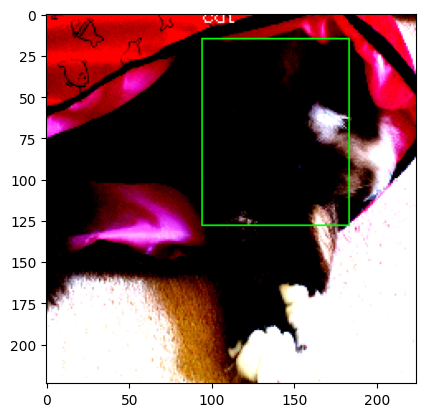

In [19]:
display_img(np.array(res[0][0]),res[1][0]['boxes']*215,res[1][0]['labels'])

In [20]:
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [21]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=32,
                 embedding_dim:int=128):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [22]:
patch_size=16

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)



set_seeds()
patchify = PatchEmbedding(in_channels=3,
                          patch_size=32,
                          embedding_dim=100)
print(f"Input image shape: {torch.stack(res[:][0]).shape}")
patch_embedded_image = patchify(torch.stack(res[:][0]).permute(0,3, 2, 1).float())
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([16, 224, 224, 3])
Output patch embedding shape: torch.Size([16, 49, 100])


In [23]:
class Positional_Encoding(nn.Module):
    def __init__(self,
                 max_length,
                 embedding_dim):
        self.max_length=max_length
        self.embedding_dim=embedding_dim
        super().__init__()
    def forward(self, x):
        position = torch.arange(0, self.max_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.embedding_dim, 2, dtype=torch.float32) * (-np.log(10000.0) / self.embedding_dim))
        pos_encodings = torch.zeros(self.max_length, self.embedding_dim)
        pos_encodings[:, 0::2] = torch.sin(position * div_term)
        pos_encodings[:, 1::2] = torch.cos(position * div_term)
        batch_size = x.size(0)
        pos_encodings = pos_encodings.unsqueeze(0).expand(batch_size, -1, -1).to('cuda')
        embedding_with_pos_encodings = x.to('cuda') + pos_encodings
        return embedding_with_pos_encodings

In [24]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=128,
                 num_heads:int=8,
                 attn_dropout:float=0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [25]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=128,
                 mlp_size:int=2048,
                 dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [26]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=128,
                 num_heads:int=8,
                 mlp_size:int=2048,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x =  self.msa_block(x) + x
        x = self.mlp_block(x) + x

        return x



In [27]:
!pip install torchinfo

In [28]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 128),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 128]        [1, 197, 128]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 128]        [1, 197, 128]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 128]        [1, 197, 128]        256                  True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 128]        66,048               True
├─MLPBlock (mlp_block)                             [1, 197, 128]        [1, 197, 128]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 128]        [1, 197, 128]        256                  True
│    └─Sequential (mlp)                            [1, 197, 128]        [1, 197, 128]        --                   True
│    │    └─Linear (0)                     

In [53]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=8,
                 num_transformer_layers:int=4,
                 embedding_dim:int=128,
                 mlp_size:int=2048,
                 num_heads:int=8,
                 attn_dropout:float=0.2,
                 mlp_dropout:float=0.2,
                 embedding_dropout:float=0.2,
                 num_classes:int=2):
        super().__init__()


        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.sq=nn.Linear(in_features=(((img_size//patch_size)**2)+1)*embedding_dim,out_features=embedding_dim)
        self.bbox_regression_head = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=4)
        )
        self.classification_head = nn.Sequential(
                    nn.LayerNorm(normalized_shape=embedding_dim),
                    nn.Linear(in_features=embedding_dim,
                              out_features=num_classes)
                )
        self.num_boxes = 1
        self.sigmoid=torch.nn.Sigmoid()
    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        class_preds=x.mean(dim=1)
        x = x.view(x.size(0), -1)
        x=self.sq(x)
        bbox_preds = self.bbox_regression_head(x)
        class_preds = self.classification_head(class_preds)
        bbox_preds = bbox_preds.view(batch_size, self.num_boxes, 4)
        class_preds = class_preds.view(batch_size, self.num_boxes, -1)
        class_preds=self.sigmoid(class_preds)

        return bbox_preds,class_preds

In [58]:
vit = ViT(num_classes=1).to('cuda')
vit

ViT(
  (embedding_dropout): Dropout(p=0.2, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 128, kernel_size=(8, 8), stride=(8, 8))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.2, inplace=False)
          (3): Linear(in_features=2048, out_features=128, bias=True)
          (4): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (1

In [59]:
bbpred=vit(torch.stack(res[:][0]).permute(0,3, 2, 1).float().to('cuda'))

In [60]:
from torch.optim.rmsprop import RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
NUM_EPOCHS=50
optimizer = optim.AdamW(vit.parameters(), lr=1e-3,weight_decay=0.0001)
# optimizer=RMSprop(net.parameters(),lr=0.001,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=75, eta_min=0.00001, last_epoch=-1, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

ce = nn.BCELoss()
# mse=nn.functional.mse_loss()
mae=nn.L1Loss()

Adjusting learning rate of group 0 to 1.0000e-03.


In [33]:
def calculate_iou_batch(boxes_pred, boxes_target):
    x_pred, y_pred, right_edge_pred, bottom_edge_pred = boxes_pred.split(1, dim=1)
    x_target, y_target, right_edge_target, bottom_edge_target = boxes_target.split(1, dim=1)
    x_left = torch.max(x_pred, x_target)
    y_top = torch.max(y_pred, y_target)
    x_right = torch.min(right_edge_pred, right_edge_target)
    y_bottom = torch.min(bottom_edge_pred, bottom_edge_target)
    intersection_area = torch.clamp(x_right - x_left, min=0) * torch.clamp(y_bottom - y_top, min=0)
    area_pred = (right_edge_pred - x_pred) * (bottom_edge_pred - y_pred)
    area_target = (right_edge_target - x_target) * (bottom_edge_target - y_target)
    union_area = area_pred + area_target - intersection_area
    valid_union_mask = union_area > 0
    iou = torch.zeros_like(intersection_area)
    iou[valid_union_mask] = intersection_area[valid_union_mask] / union_area[valid_union_mask]
    return iou.mean()


In [61]:

import numpy as np
from torch.nn.utils import clip_grad_norm_
avg_train_loss=[]
avg_val_loss=[]
train_accuracy_class=[]
val_accuracy_class=[]
avg_train_iou=[]
avg_val_iou=[]
alpha1=0.90
alpha2=0.01
model_filename = 'final_od.pth'

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    validation_loss=0
    train_correct = 0
    train_total = 0
    val_correct = 0
    val_total = 0
    train_accuracy_iou=0
    val_accuracy_iou=0
    vit.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs=torch.stack(inputs).to('cuda')
        boxes = [item['boxes'].to('cuda') for item in labels]
        labels = [item['labels'].to('cuda') for item in labels]
        optimizer.zero_grad()
        bounding_boxes,label_pred = vit(inputs.permute(0,3,1,2))
        labels = torch.tensor(labels).to('cuda',dtype=torch.float32)
        label_pred=label_pred.squeeze(dim=1)
        label_pred=label_pred.squeeze(dim=1)
        bounding_boxes=bounding_boxes.squeeze(dim=1)
        boxes=[item for item in boxes]
        boxes=torch.stack(boxes)
        ce_loss = ce(label_pred, labels)
        loss2=nn.functional.mse_loss(bounding_boxes,boxes)
        train_iou=calculate_iou_batch(bounding_boxes,boxes).to('cuda')
        loss=(ce_loss+loss2)

        loss.backward()
        max_norm = 10
        clip_grad_norm_(vit.parameters(), max_norm)

        optimizer.step()
        predicted=torch.round(label_pred)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_accuracy_iou+=train_iou
        running_loss += loss.item()
    vit.eval()
    with torch.no_grad():
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs=torch.stack(inputs).to('cuda')
            boxes = [item['boxes'].to('cuda') for item in labels]
            labels = [item['labels'].to('cuda') for item in labels]
            optimizer.zero_grad()
            bounding_boxes,label_pred = vit(inputs.permute(0,3,1,2))
            labels = torch.tensor(labels).to('cuda',dtype=torch.float32)
            label_pred=label_pred.squeeze(dim=1)
            label_pred=label_pred.squeeze(dim=1)
            bounding_boxes=bounding_boxes.squeeze(dim=1)
            boxes=[item for item in boxes]

            boxes=torch.stack(boxes)
            ce_loss = ce(label_pred, labels)
            loss2=nn.functional.mse_loss(bounding_boxes,boxes)
            val_loss=ce_loss+loss2
            val_iou=calculate_iou_batch(bounding_boxes,boxes).to('cuda')

            val_accuracy_iou+=val_iou
            val_predicted=torch.round(label_pred)
            val_total += labels.size(0)
            val_correct += (val_predicted == labels).sum().item()
            validation_loss += val_loss.item()



    scheduler.step()
    avg_train_loss.append(running_loss / len(train_loader))
    avg_val_loss.append(validation_loss / len(val_loader))

    train_accuracy_class.append(train_correct / train_total)
    val_accuracy_class.append(val_correct / val_total)
    avg_train_iou.append(train_accuracy_iou/len(train_loader))
    avg_val_iou.append(val_accuracy_iou/len(val_loader))
    print(
    f'Epoch: {epoch + 1}, '
    f'Training Loss: {running_loss / len(train_loader):.4f},'
    f'Validation Loss: {(validation_loss / len(val_loader)):.4f}')

torch.save(vit, model_filename)
print('Finished Training')

Adjusting learning rate of group 0 to 9.9957e-04.
Epoch: 1, Training Loss: 4410.2681, Validation Loss: 1.3111
Adjusting learning rate of group 0 to 9.9826e-04.
Epoch: 2, Training Loss: 0.7758, Validation Loss: 0.7544
Adjusting learning rate of group 0 to 9.9610e-04.
Epoch: 3, Training Loss: 0.6520, Validation Loss: 0.8215
Adjusting learning rate of group 0 to 9.9307e-04.
Epoch: 4, Training Loss: 0.6529, Validation Loss: 0.7408
Adjusting learning rate of group 0 to 9.8918e-04.
Epoch: 5, Training Loss: 0.6473, Validation Loss: 0.7346
Adjusting learning rate of group 0 to 9.8445e-04.
Epoch: 6, Training Loss: 0.6475, Validation Loss: 0.7449
Adjusting learning rate of group 0 to 9.7887e-04.
Epoch: 7, Training Loss: 0.6420, Validation Loss: 0.7208
Adjusting learning rate of group 0 to 9.7247e-04.
Epoch: 8, Training Loss: 0.6389, Validation Loss: 0.7257
Adjusting learning rate of group 0 to 9.6524e-04.
Epoch: 9, Training Loss: 0.6374, Validation Loss: 0.7231
Adjusting learning rate of group 0

In [52]:
torch.save(vit, 'final_od')

In [117]:
res=next(iter(test_loader))
with torch.no_grad():
  pred2=vit(torch.stack(res[:][0]).permute(0,3, 1, 2).float().to('cuda'))

tensor([ 17.,  15., 172., 137.])


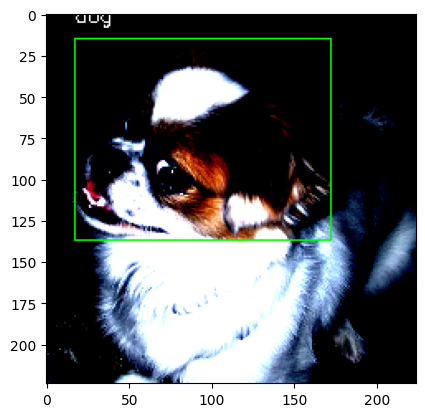

tensor([ 28.0703,  15.3998, 177.0660, 161.6669], device='cuda:0')


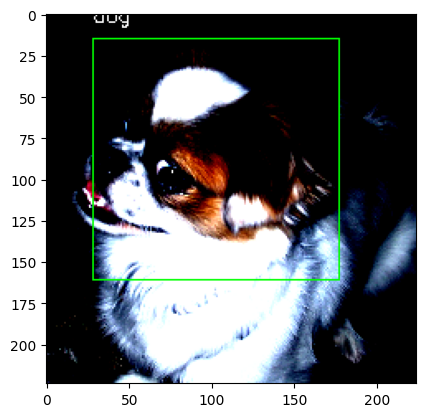

In [118]:
# pred2.squeeze(dim=1)[0],res[:][0][0]
idx=10
binary_predictions = (pred2[1] >= 0.5).float()
boxes=res[1][idx]['boxes']
# boxes = torch.cat([boxes[:2], boxes[:2] + boxes[2:]], dim=0)
display_img(np.array(res[0][idx]),res[1][idx]['boxes']*224,res[1][idx]['labels'])
display_img(np.array(res[0][idx]),pred2[0][idx][0]*224,binary_predictions[idx][0])
# display_img(np.array(res[0][idx]),pred2.squeeze(dim=1)[idx],res[1][idx]['labels'])

In [78]:
import pickle
file = open('/content/drive/MyDrive/Colab_Notebooks/data/avg_train_loss', 'wb')

m = pickle.dump(avg_train_loss,file)

In [39]:
import pickle
file = open('/content/drive/MyDrive/Colab_Notebooks/data/avg_val_loss', 'wb')

m = pickle.dump(avg_val_loss,file)

In [40]:
import pickle
file = open('/content/drive/MyDrive/Colab_Notebooks/data/train_accuracy_class', 'wb')

m = pickle.dump(train_accuracy_class,file)

In [41]:
import pickle
file = open('/content/drive/MyDrive/Colab_Notebooks/data/val_accuracy_class', 'wb')

m = pickle.dump(val_accuracy_class,file)

In [42]:
import pickle
file = open('/content/drive/MyDrive/Colab_Notebooks/data/avg_val_iou', 'wb')

m = pickle.dump(avg_val_iou,file)

In [43]:
import pickle
file = open('/content/drive/MyDrive/Colab_Notebooks/data/avg_train_iou', 'wb')

m = pickle.dump(avg_train_iou,file)

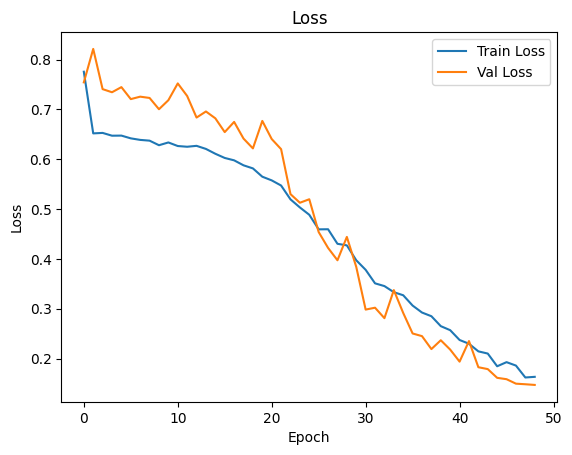

In [119]:
import matplotlib.pyplot as plt
plt.plot(np.array(avg_train_loss))
plt.plot(np.array(avg_val_loss))
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'])
plt.show()

In [46]:
# Since the model is crashing due to high usage of RAM in google colab, we have decided to pickle all the files and then plot the graphs later. We will be attaching the saved model as well as data to to make predictions.
# And will also include the graphs in the the github repo. Thank you!!

# While calculating MeanIOU scores for both train and validation data, sometimes RAM is being used to its fullest even after optimizing the code, and was not able to complete the training.